# HW3

### Prob1.

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
alpha = 0.1
K = 1000
B = 128
N = 512

In [3]:
def f_true(x) :
    return (x-2) * np.cos(x*4)

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self._initialize_weights()
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return self.fc3(x)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1)
                nn.init.constant_(m.bias, 0.03)

The MLP class composed with 3 linear layers with the sigmoid activation is implemented as above, and they are initialized such that the weight is from the unit Gaussian and the bias is a constant value of 0.03

In [5]:
torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B, shuffle = True)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

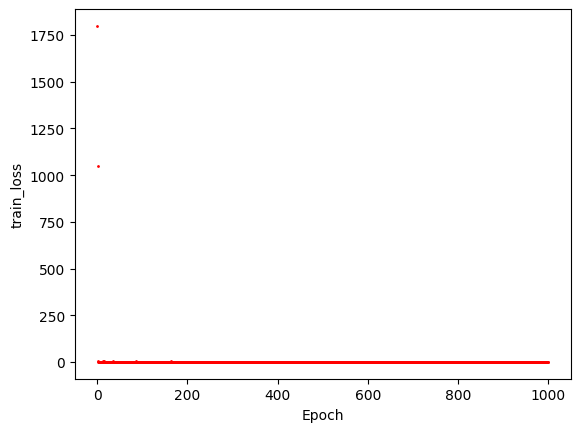

final loss:0.08103169267997146


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=alpha)

train_loss = 0
for epoch in range(K):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    plt.plot(epoch, train_loss, 'ro', markersize=1)
        
plt.xlabel('Epoch')
plt.ylabel('train_loss')
plt.show()

print(f"final loss:{train_loss}")

SGD is performed as above, and the train loss is calculated as mean of the (MSE among the batch) among the datas, and is plotted as above. The loss seems to converge, and the final loss value is 0.081.

In [7]:
test_loss = 0
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        test_loss += loss_function(y_pred, y_batch).item()
    test_loss /= len(test_dataloader)

print(f"final test_loss:{test_loss}")

final test_loss:0.08446330577135086


The test_loss is calculated on the testset, and is calculated as the mean of the (mean among batches) among the data, which is the same way the train_loss is calculated. The test_loss is 0.084 which is slightly bigger than the train_loss which is suitable.

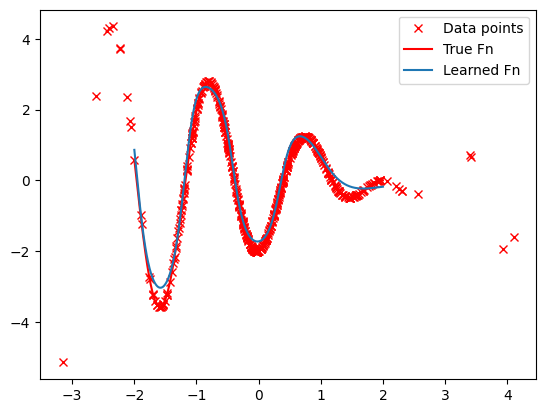

In [8]:
with torch.no_grad():
    xx = torch.linspace(-2,2,1024).unsqueeze(1)
    plt.plot(X_train,y_train,'rx',label='Data points')
    plt.plot(xx,f_true(xx),'r',label='True Fn')
    plt.plot(xx, model(xx),label='Learned Fn')
plt.legend()
plt.show()

We can check the trained neural network well approximates the given data points as depicted in the graph.

### Prob 2.

In [9]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(num_trainable_params)

4353


The number of trainable parameters are 4353, which are bigger than the number of data points N which is 512.

In [10]:
torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train) + torch.normal(0, 0.5, X_train.shape)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B, shuffle = True)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

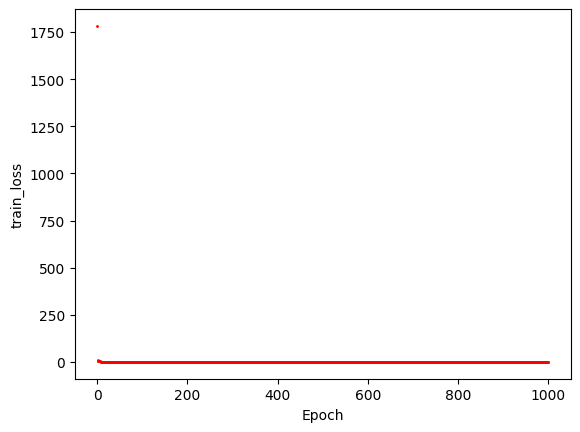

final loss:0.33605487644672394


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=alpha)

train_loss = 0
for epoch in range(K):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    plt.plot(epoch, train_loss, 'ro', markersize=1)
        
plt.xlabel('Epoch')
plt.ylabel('train_loss')
plt.show()

print(f"final loss:{train_loss}")

The loss is calculated as the same way in Prob1, and the loss seems to converge and the final loss is calculated as 0.336

In [12]:
test_loss = 0
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        test_loss += loss_function(y_pred, y_batch).item()
    test_loss /= len(test_dataloader)

print(f"final test_loss:{test_loss}")

final test_loss:0.05165184661746025


The test_loss is calculated as the same as Prob1. and the test_loss is actually smaller than the train_loss. This is good in our case becaues no noise is added in the test data, and small loss on the testset is what we needed.

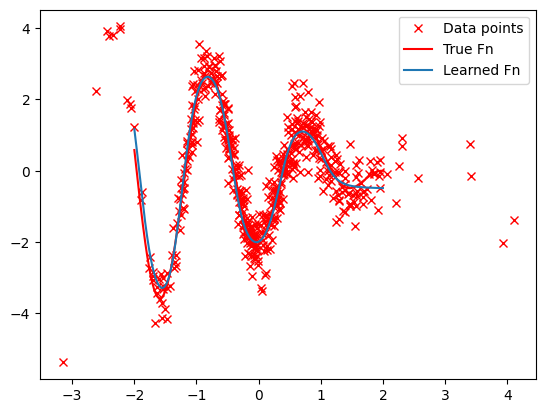

In [13]:
with torch.no_grad():
    xx = torch.linspace(-2,2,1024).unsqueeze(1)
    plt.plot(X_train,y_train,'rx',label='Data points')
    plt.plot(xx,f_true(xx),'r',label='True Fn')
    plt.plot(xx, model(xx),label='Learned Fn')
plt.legend()
plt.show()

We can see the neural network actually well approximates the underlying true function even when there are some random noise included in the data. The neural network doesn't overfit to the data and well approximates the true function.